# Exercise 4.5

## 4.5(a)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

In [2]:
#parse date coulmn in correct format
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d').date()
data = pd.read_csv('./climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCountry.csv',parse_dates = ['dt'],date_parser = dateparse)
data_city = pd.read_csv("./climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCity.csv.gz",parse_dates = ['dt'],date_parser = dateparse,compression='gzip')


In [4]:
#Testing for stationarity

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

### By Country

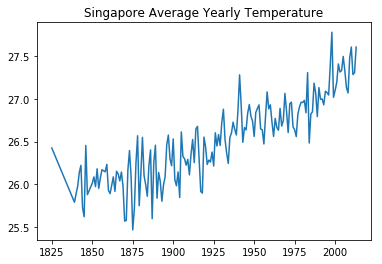

In [79]:
#Country - Singpaore
sg_temp = data.loc[data['Country']=='Singapore']
sg_temp_year = sg_temp.groupby(sg_temp['dt'].dt.year).mean()['AverageTemperature']
sg_temp_year.dropna(inplace=True)
plt.plot(sg_temp_year)
plt.title('Singapore Average Yearly Temperature')
plt.show()

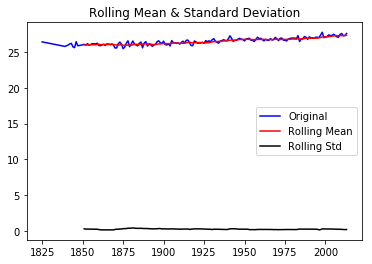

Results of Dickey-Fuller Test:
Test Statistic                   0.885018
p-value                          0.992892
#Lags Used                      10.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


In [14]:
test_stationarity(sg_temp_year.loc[sg_temp_year.notnull()])
#p-value = 0.99
#cannot reject H0 at 5% significance level-> not stationary

p-value > 0.05. Not stationary

In [10]:
sg_temp_log = np.log(sg_temp_year) #log data values to reduce effect of outliers
sg_temp_log.dropna(inplace=True)
#sg_temp_log = sg_temp_year #use if you do not want to use log

#### Moving Average

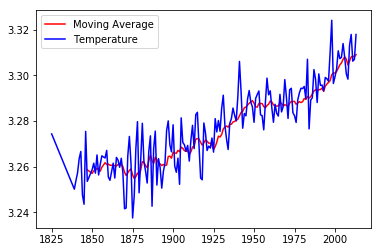

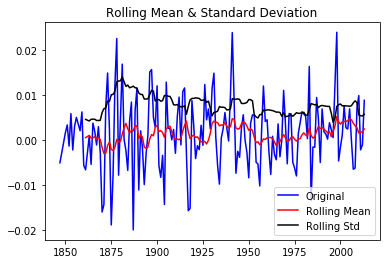

Results of Dickey-Fuller Test:
Test Statistic                -1.088748e+01
p-value                        1.249344e-19
#Lags Used                     1.000000e+00
Number of Observations Used    1.610000e+02
Critical Value (1%)           -3.471633e+00
Critical Value (5%)           -2.879665e+00
Critical Value (10%)          -2.576434e+00
dtype: float64


In [11]:
#Moving Average
moving_average = sg_temp_log.rolling(window=10).mean()
plt.plot(moving_average,'r')
plt.plot(sg_temp_log,'b')
plt.legend(['Moving Average','Temperature'])
plt.show()

sg_temp_log_sub_ma = sg_temp_log - moving_average
sg_temp_log_sub_ma.dropna(inplace=True)
test_stationarity(sg_temp_log_sub_ma)

print ()
#check stationarity again -> stationary

p-value is < 0.05. Stationary

#### Exponentially weighted moving average

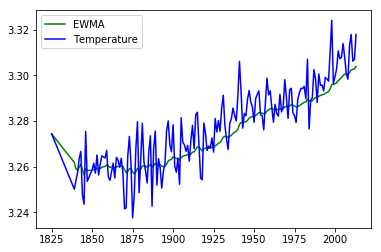

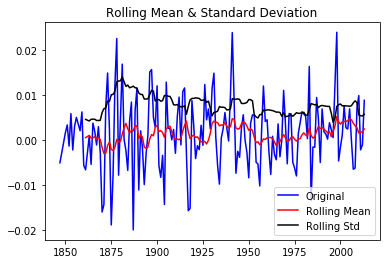

Results of Dickey-Fuller Test:
Test Statistic                -1.088748e+01
p-value                        1.249344e-19
#Lags Used                     1.000000e+00
Number of Observations Used    1.610000e+02
Critical Value (1%)           -3.471633e+00
Critical Value (5%)           -2.879665e+00
Critical Value (10%)          -2.576434e+00
dtype: float64


In [13]:
expweighted_avg = sg_temp_log.ewm(halflife=10).mean()
plt.plot(expweighted_avg,color='green')
plt.plot(sg_temp_log,'b')
plt.legend(['EWMA','Temperature'])
plt.show()

sg_temp_log_sub_ewma = sg_temp_log - expweighted_avg
sg_temp_log_sub_ewma.dropna(inplace=True)
test_stationarity(sg_temp_log_sub_ma)

p-value < 0.05. Stationary

### Eliminating trend an seasonality

#### Differencing

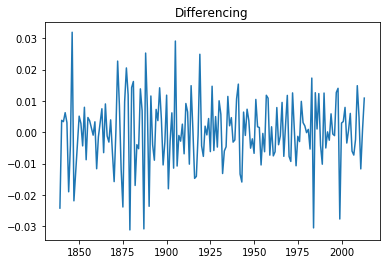

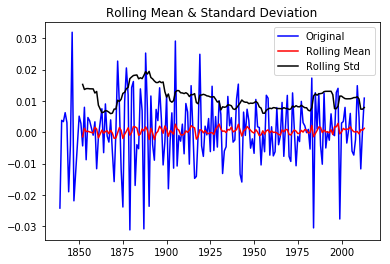

Results of Dickey-Fuller Test:
Test Statistic                -7.538298e+00
p-value                        3.431443e-11
#Lags Used                     9.000000e+00
Number of Observations Used    1.610000e+02
Critical Value (1%)           -3.471633e+00
Critical Value (5%)           -2.879665e+00
Critical Value (10%)          -2.576434e+00
dtype: float64


In [16]:
sg_temp_log_diff = sg_temp_log-sg_temp_log.shift()
plt.plot(sg_temp_log_diff)
plt.title('Differencing')
plt.show()

sg_temp_log_diff.dropna(inplace=True)
test_stationarity(sg_temp_log_diff)

#### Deomposition

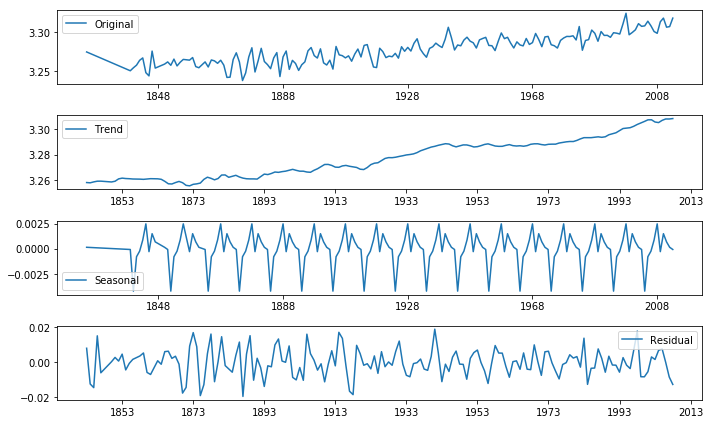

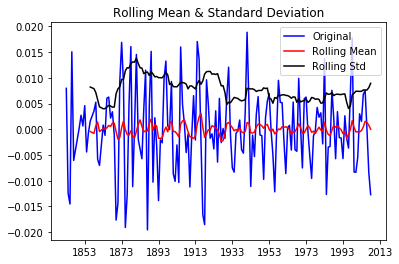

Results of Dickey-Fuller Test:
Test Statistic                -6.619780e+00
p-value                        6.078063e-09
#Lags Used                     1.400000e+01
Number of Observations Used    1.470000e+02
Critical Value (1%)           -3.475637e+00
Critical Value (5%)           -2.881410e+00
Critical Value (10%)          -2.577365e+00
dtype: float64


In [27]:
# change format to datetime format so can be read by function
a = pd.to_datetime(sg_temp_log.index,format = '%Y')
sg_temp_log = sg_temp_log.set_index(a)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(sg_temp_log,freq=10)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplots(figsize=(10,6))
plt.subplot(411)
plt.plot(sg_temp_log, label = 'Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

sg_temp_decompose = residual.squeeze()
sg_temp_decompose.dropna(inplace=True)
test_stationarity(sg_temp_decompose)

### Forecasting

#### ACF & PACF plots

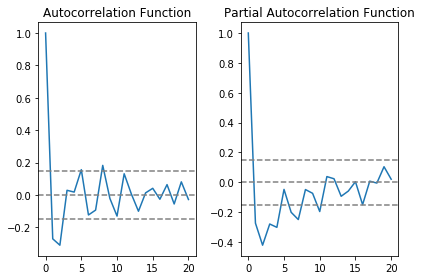

In [29]:
from statsmodels.tsa.arima_model import ARIMA
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf 
lag_acf = acf(sg_temp_log_diff,nlags=20)
lag_pacf = pacf(sg_temp_log_diff,nlags=20, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(sg_temp_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(sg_temp_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(sg_temp_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(sg_temp_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

#### AR Model

c:\users\jing yun\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\jing yun\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\jing yun\appdata\local\programs\python\python37\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[

Text(0.5,1,'RSS: 0.0158')

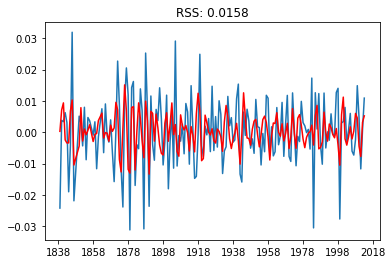

In [37]:
a = pd.to_datetime(sg_temp_log_diff.index,format = '%Y')
sg_temp_log_diff = sg_temp_log_diff.to_frame()
sg_temp_log_diff = sg_temp_log_diff.set_index(a)
sg_temp_log_diff = sg_temp_log_diff.iloc[:,0]

model = ARIMA(sg_temp_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(sg_temp_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-sg_temp_log_diff)**2))

#### MA Model

c:\users\jing yun\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\jing yun\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


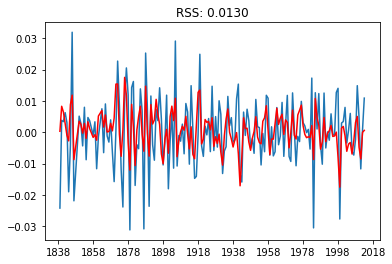

In [39]:
model = ARIMA(sg_temp_log, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(sg_temp_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-sg_temp_log_diff)**2))
plt.show()

#### ARIMA Model 

c:\users\jing yun\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\jing yun\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


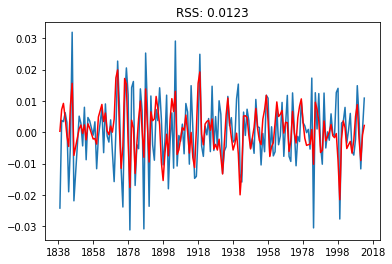

In [40]:
#ARIMA model
model = ARIMA(sg_temp_log, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(sg_temp_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-sg_temp_log_diff)**2))
plt.show()

#### Convert to original scale

In [80]:
#prepare singapore temperature data for graphing
a = pd.to_datetime(sg_temp.dt,format = '%Y')
sg_temp = sg_temp.set_index(a)
sg_temp = sg_temp.iloc[:,1]
sg_temp.dropna(inplace=True)

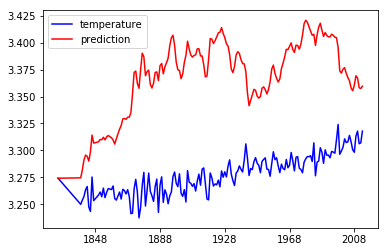

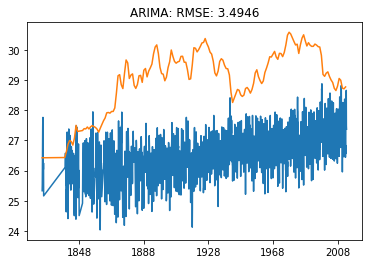

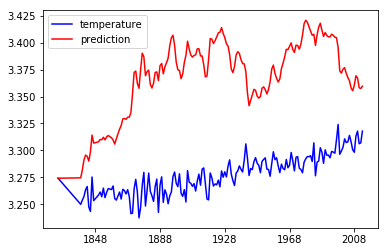

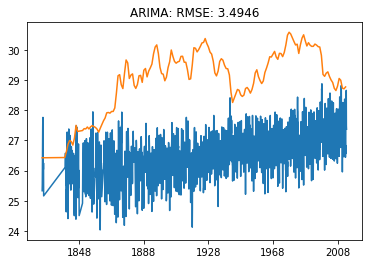

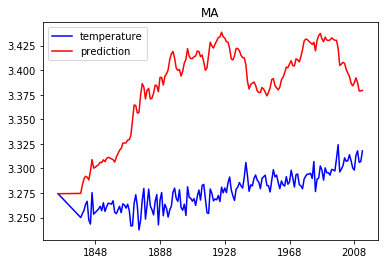

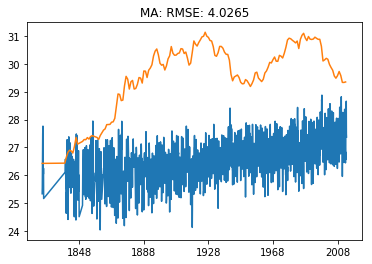

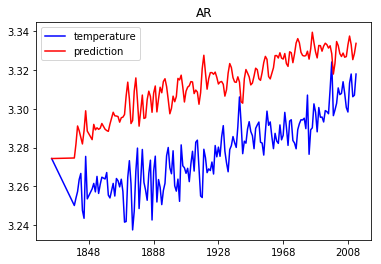

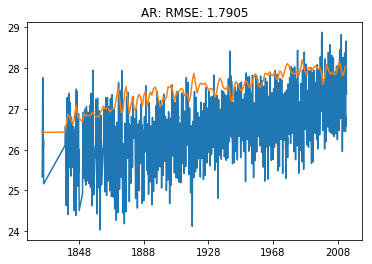

In [96]:
#Convert to original scale
pred_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
pred_ARIMA_diff_cumsum = pred_ARIMA_diff.cumsum() #cumulative sum
sg_temp_log_2 = sg_temp_log.iloc[:,0]
pred_ARIMA_log = pd.Series(sg_temp_log_2.iloc[0], index=sg_temp_log_2.index)
pred_ARIMA_log = pred_ARIMA_log.add(pred_ARIMA_diff_cumsum, fill_value =0 )

plt.plot(sg_temp_log_2,'b', label='temperature')
plt.plot(pred_ARIMA_log,'r',label='prediction')
plt.legend()
plt.show()

predictions_ARIMA = np.exp(pred_ARIMA_log)
# prep data for graphing
plt.plot(sg_temp,label='temperature')
plt.plot(predictions_ARIMA,label='pred')
diff = predictions_ARIMA-sg_temp
diff.dropna(inplace=True)
plt.title('ARIMA: RMSE: %.4f'% np.sqrt(sum((diff)**2)/min(len(sg_temp),len(predictions_ARIMA))))
plt.show()

### MA model  ###
pred_MA_diff = pd.Series(results_MA.fittedvalues, copy=True)
pred_MA_diff_cumsum = pred_MA_diff.cumsum() #cumulative sum
pred_MA_log = pd.Series(sg_temp_log_2.iloc[0], index=sg_temp_log_2.index)
pred_MA_log = pred_MA_log.add(pred_MA_diff_cumsum, fill_value =0 )

plt.plot(sg_temp_log_2,'b', label='temperature')
plt.plot(pred_MA_log,'r',label='prediction')
plt.title('MA')
plt.legend()
plt.show()

predictions_MA = np.exp(pred_MA_log)
# prep data for graphing
plt.plot(sg_temp,label='temperature')
plt.plot(predictions_MA,label='pred')
diff = predictions_MA-sg_temp
diff.dropna(inplace=True)
plt.title('MA: RMSE: %.4f'% np.sqrt(sum((diff)**2)/min(len(sg_temp),len(predictions_MA))))
plt.show()


### AR Model###
pred_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)
pred_AR_diff_cumsum = pred_AR_diff.cumsum() #cumulative sum
pred_AR_log = pd.Series(sg_temp_log_2.iloc[0], index=sg_temp_log_2.index)
pred_AR_log = pred_AR_log.add(pred_AR_diff_cumsum, fill_value =0 )

plt.plot(sg_temp_log_2,'b', label='temperature')
plt.plot(pred_AR_log,'r',label='prediction')
plt.title('AR')
plt.legend()
plt.show()

predictions_AR = np.exp(pred_AR_log)
# prep data for graphing
plt.plot(sg_temp,label='temperature')
plt.plot(predictions_AR,label='pred')
diff = predictions_AR-sg_temp
diff.dropna(inplace=True)
plt.title('AR: RMSE: %.4f'% np.sqrt(sum((diff)**2)/min(len(sg_temp),len(predictions_AR))))
plt.show()


AR seems to have the least RMSE

c:\users\jing yun\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
c:\users\jing yun\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
c:\users\jing yun\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
c:\users\jing yun\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


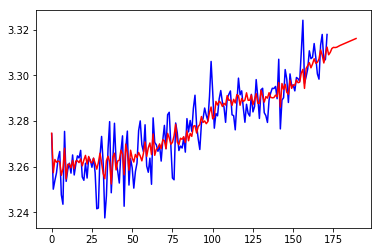

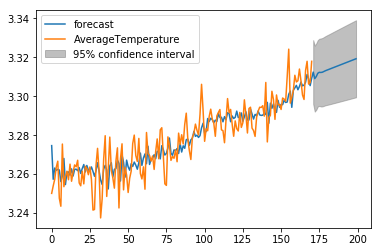

In [78]:
pred = results_ARIMA.predict(1,190,typ='levels')
plt.plot(sg_temp_log_2.values,'b')
plt.plot(pred,'r')

results_ARIMA.plot_predict(start=1,end=200)
plt.show()

### By City

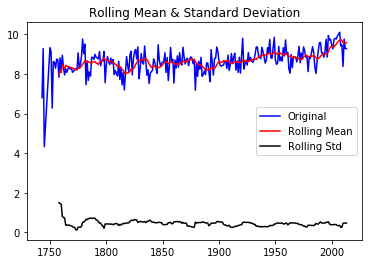

Results of Dickey-Fuller Test:
Test Statistic                  -3.236769
p-value                          0.017953
#Lags Used                       6.000000
Number of Observations Used    260.000000
Critical Value (5%)             -2.872721
Critical Value (1%)             -3.455754
Critical Value (10%)            -2.572728
dtype: float64


In [199]:
city_temp = data_city.loc[data_city.City == 'Dublin'][['AverageTemperature','dt']]
city_temp_year = city_temp.groupby(city_temp['dt'].dt.year).mean()
city_temp_year.AverageTemperature.dropna(inplace=True)

test_stationarity(city_temp_year['AverageTemperature'])

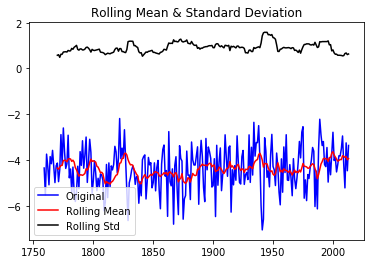

Results of Dickey-Fuller Test:
Test Statistic                -1.363219e+01
p-value                        1.714888e-25
#Lags Used                     0.000000e+00
Number of Observations Used    2.540000e+02
Critical Value (5%)           -2.872987e+00
Critical Value (1%)           -3.456360e+00
Critical Value (10%)          -2.572870e+00
dtype: float64


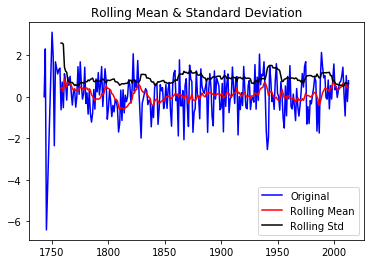

Results of Dickey-Fuller Test:
Test Statistic                -1.695853e+01
p-value                        9.346147e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.660000e+02
Critical Value (5%)           -2.872468e+00
Critical Value (1%)           -3.455175e+00
Critical Value (10%)          -2.572593e+00
dtype: float64


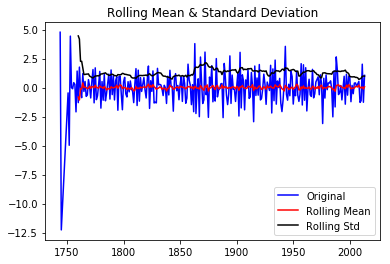

Results of Dickey-Fuller Test:
Test Statistic                -7.537367e+00
p-value                        3.449916e-11
#Lags Used                     1.200000e+01
Number of Observations Used    2.520000e+02
Critical Value (5%)           -2.873079e+00
Critical Value (1%)           -3.456569e+00
Critical Value (10%)          -2.572919e+00
dtype: float64


In [87]:
#Moving average smoothing
city_temp_MA = city_temp_year-roll_mean
test_stationarity(city_temp_MA.AverageTemperature.dropna())

#EWMA smoothing

city_temp_ewma = city_temp_year-city_temp_year.ewm(halflife=10).mean()
test_stationarity(city_temp_ewma.AverageTemperature.dropna())


#Differencing

city_temp_diff = city_temp_year-city_temp_year.shift()
test_stationarity(city_temp_diff.AverageTemperature.dropna())

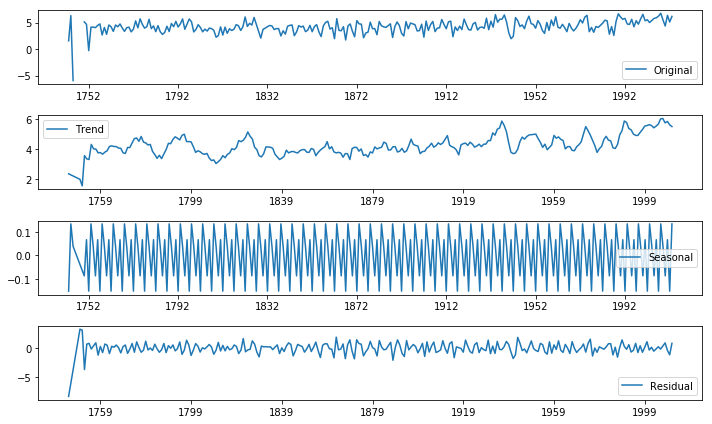

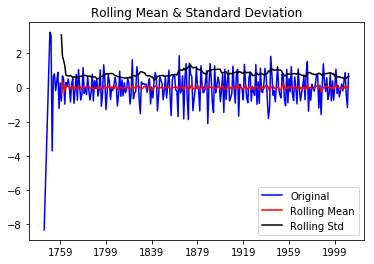

Results of Dickey-Fuller Test:
Test Statistic                -8.550132e+00
p-value                        9.271293e-14
#Lags Used                     1.600000e+01
Number of Observations Used    2.460000e+02
Critical Value (5%)           -2.873362e+00
Critical Value (1%)           -3.457215e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


In [88]:
#Decomposition
city_temp_year_decom=city_temp_year.set_index(pd.to_datetime(city_temp_year.index, format='%Y'))
decompose = seasonal_decompose(city_temp_year_decom.AverageTemperature.dropna(),freq=5)
trend = decompose.trend
seasonal = decompose.seasonal
residual = decompose.resid

plt.subplots(figsize=(10,6))
plt.subplot(411)
plt.plot(city_temp_year_decom, label = 'Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

city_temp_decompose = residual.squeeze()
city_temp_decompose.dropna(inplace=True)
test_stationarity(city_temp_decompose)


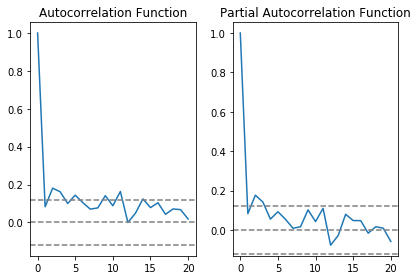

In [90]:
#Forecasting
#ACF and PACF plots:

d = city_temp_year
d = city_temp_year.set_index(pd.to_datetime(city_temp_year.index, format='%Y'))
d=d.dropna()
from statsmodels.tsa.stattools import acf, pacf 
lag_acf = acf(d,nlags=20)
lag_pacf = pacf(d,nlags=20)

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(d)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(d)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(d)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(d)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

/Users/justin/anaconda/envs/py35/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/justin/anaconda/envs/py35/lib/python2.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/justin/anaconda/envs/py35/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


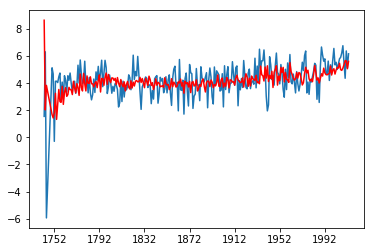

/Users/justin/anaconda/envs/py35/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/justin/anaconda/envs/py35/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


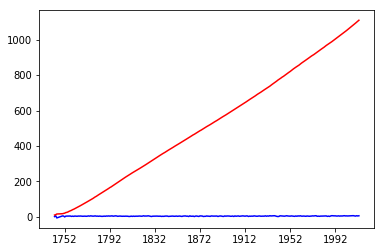

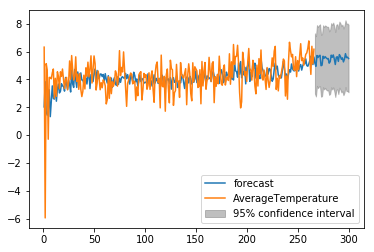

In [91]:
#ARIMA model
model = ARIMA(d,order=(12,0,12))
results_ARIMA = model.fit(disp=-1)
plt.plot(d)
plt.plot(results_ARIMA.fittedvalues, color='red')
#plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-d)**2))
plt.show()

predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(float(d.iloc[0]), index=d.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
plt.plot(d,'b')
plt.plot(predictions_ARIMA_log,'r')

results_ARIMA.plot_predict(start=1,end=300)
plt.show()

## 4.5(b)

In [270]:
#KNNDTW

import sys
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.spatial.distance import squareform

plt.style.use('bmh')
#%matplotlib inline

try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

class KnnDtw(object):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays
    
    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for KNN
        
    max_warping_window : int, optional (default = infinity)
        Maximum warping window allowed by the DTW dynamic
        programming function
            
    subsample_step : int, optional (default = 1)
        Step size for the timeseries array. By setting subsample_step = 2,
        the timeseries length will be reduced by 50% because every second
        item is skipped. Implemented by x[:, ::subsample_step]
    """
    
    def __init__(self, n_neighbors=5, max_warping_window=10000, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    
    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
            Training data set for input into KNN classifer
            
        l : array of shape [n_samples]
            Training labels for input into KNN classifier
        """
        
        self.x = x
        self.l = l
        
    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
        """Returns the DTW similarity distance between two 2-D
        timeseries numpy arrays.

        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
            Two arrays containing n_samples of timeseries data
            whose DTW distance between each sample of A and B
            will be compared
        
        d : DistanceMetric object (default = abs(x-y))
            the distance measure used for A_i - B_j in the
            DTW dynamic programming function
        
        Returns
        -------
        DTW distance between A and B
        """

        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = sys.maxint * np.ones((M, N))

        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in xrange(1, M):
            cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

        for j in xrange(1, N):
            cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

        # Populate rest of cost matrix within window
        for i in xrange(1, M):
            for j in xrange(max(1, i - self.max_warping_window),
                            min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

        # Return DTW distance given window 
        return cost[-1, -1]
    
    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        
        y : array of shape [n_samples, n_timepoints]
        
        Returns
        -------
        Distance matrix between each item of x and y with
            shape [training_n_samples, testing_n_samples]
        """
        
        # Compute the distance matrix        
        dm_count = 0
        
        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if(np.array_equal(x, y)):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            
            p = ProgressBar(shape(dm)[0])
            
            for i in xrange(0, x_s[0] - 1):
                for j in xrange(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],
                                                      y[j, ::self.subsample_step])
                    
                    dm_count += 1
                    p.animate(dm_count)
            
            # Convert to squareform
            dm = squareform(dm)
            return dm
        
        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0])) 
            dm_size = x_s[0]*y_s[0]
            
            p = ProgressBar(dm_size)
        
            for i in xrange(0, x_s[0]):
                for j in xrange(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],
                                                  y[j, ::self.subsample_step])
                    # Update progress bar
                    dm_count += 1
                    p.animate(dm_count)
        
            return dm
        
    def predict(self, x):
        """Predict the class labels or probability estimates for 
        the provided data

        Arguments
        ---------
          x : array of shape [n_samples, n_timepoints]
              Array containing the testing data set to be classified
          
        Returns
        -------
          2 arrays representing:
              (1) the predicted class labels 
              (2) the knn label count probability
        """
        
        dm = self._dist_matrix(x, self.x)

        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]
        
        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1]/self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()

class ProgressBar:
    """This progress bar was taken from PYMC
    """
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython

    def animate_ipython(self, iter):
        print '\r', self,
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)

In [271]:
df_byCountry = pd.read_csv('/Users/justin/Desktop/Data Science/TS/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCountry.csv')
countries = ['Norway','Finland','Singapore','Cambodia']
df_filtered = df_byCountry.loc[df_byCountry['Country'].isin(countries)]
colours = ['#D62728','#2C9F2C','#FD7F23','#1F77B4']

dateTime = pd.to_datetime(df_filtered['dt'],format = '%Y-%m-%d')
df_country = pd.concat([dateTime,df_filtered.iloc[:,1:]],axis=1)
df_byYear = df_country.groupby([df_country['dt'].dt.year,df_country['Country']],as_index=False, group_keys=False).mean()


In [311]:


df_norway = df_country.loc[df_country['Country']==countries[0]].groupby([df_country['dt'].dt.year],as_index=True, group_keys=False).mean()
df_finland = df_country.loc[df_country['Country']==countries[1]].groupby([df_country['dt'].dt.year],as_index=True, group_keys=False).mean()
df_sg = df_country.loc[df_country['Country']==countries[2]].groupby([df_country['dt'].dt.year],as_index=True, group_keys=False).mean()
df_cam = df_country.loc[df_country['Country']==countries[3]].groupby([df_country['dt'].dt.year],as_index=True, group_keys=False).mean()
df_all = [df_norway,df_finland,df_sg,df_cam]

#Differencing

dist_matrix = np.zeros((4,4))
m = KnnDtw()
for i in range(4):
    for j in range(4):
        arr1 = df_all[i].loc[df_all[i]['AverageTemperature'].notnull()]['AverageTemperature']
        arr2 = df_all[j].loc[df_all[j]['AverageTemperature'].notnull()]['AverageTemperature']
        arr1_diff = arr1 - arr1.shift()
        arr2_diff = arr2 - arr2.shift()
        arr1_diff = arr1_diff.dropna()
        arr2_diff = arr2_diff.dropna()
        dist_matrix[i][j] = m._dtw_distance(arr1_diff.values,arr2_diff.values)
dist_df = pd.DataFrame(dist_matrix, countries,countries)
print "Distance Matrix: " + "\n"  
print dist_df


Distance Matrix: 

               Norway     Finland   Singapore    Cambodia
Norway       0.000000  123.373667  176.889616  170.059536
Finland    123.373667    0.000000  254.092298  246.224274
Singapore  176.889616  254.092298    0.000000   30.644785
Cambodia   170.059536  246.224274   30.644785    0.000000
